# Container Pre-marshalling Problem Enviroment
En el siguiente documento se documentará cómo es que funciona el CPMP Enviroment

## Contenidos
[Valores Relevantes](#relevant)

[Acciones](#actions)

[Observaciones](#observation)

[Demonstración](#demo)
- [Crear el estado y Manipularlo](#createstate)
- [Representación del Patio de Containers (yard.py)](#representation)
- [Ambiente de CPMP (containeryard.py)](#ambient)
- [Pruebas](#test)

[Generador de Instancias](#generate)

[Ejecutar el Ambiente](#execute)



## <a name="relevant"></a> Valores Relevantes

state : Es la representación del estado actual, de tipo 'Yard' para permitir realizarle cambios al estado

showDebug : Valor booleano que dicta si mostrará información de Debug o no

max_step : Pasos máximos, cálculados por una solución greedy. La idea es que la red mejore lo que dicta el greedy en StackedYard.py

training :  booleano que dice si está entrenando o no. Más que nada para ver qué conjunto utilizará para trabajar.

fileStack :  Los archivos que contienen los estados

current_step : Paso actual del estado, la idea es que sea menor a max_step

last_reward : la última recompenza obtenida, utilizada para recompenzar la diferencia entre la actual recompenza y la anterior (last_reward)


## <a name="actions"></a>Acciones
La acción que entregará como output va a ser un número de 0 a x, dónde x será la anchura del estado

Este valor representa el stack en el cuál se debe realizar la acción. En la actualidad, la red identificará un stack y una función de greedy realizará el cambio en dicho stack seleccionado.

```py
self.action_space = spaces.Discrete(x) # de 0 a x
```

## <a name="observation"></a>Observaciones
La observación será un arreglo que contendrá:

1)  El estado actual del patio con los containers, primero los datos vacios y luego los que poseen un valor, de tal manera que los que tienen valor se "eleven" y dejen a los ceros arriba. Posterior a esto, se realizaran dos normalizaciones, una que "Compactará" los valores, para que siempre esten en rangos iguales, y, una normalización de mayor y menor. Algo así:

![Imagen Explicativa de Observacion](https://i.imgur.com/0u1Exr9.png "Ejemplo Observacion")

Los valores equivalentes al container son numeros enteros pertenecientes a `[0,∞)`. 
La representación dentro de la observación los normalizara en un rango de `[0,1]`, utilizando una normalización min-max, dónde el minimo y el maximo dependera del  problema que se este resolviendo.

2) Además de los valores del estado en sí, se cuenta con un valor booleano (0 ó 1) que representará si una columna se encuentra en orden (1) o no (0).


Algo así se vería lo que alimenta a la red.
```
[0.00833333 0.06666667 0.05       0.01666667 0.025      0.06666667
 0.06666667 0.06666667 0.06666667 0.01666667 0.05833333 0.06666667
 0.06666667 0.00833333 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.04166667 0.03333333 0.06666667 0.06666667 0.05833333
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.05833333
 0.05833333 0.06666667 0.06666667 0.         0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.03333333 0.03333333 0.06666667
 0.06666667 0.05       0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.05       0.         1.         1.         0.
 1.         1.         1.         1.         1.         0.        ]
```

## <a name="demo"></a>Demonstración
A continuación se explicarán funciones del ambiente con ejemplos, de modo que se pueda comprender mejor cómo es que opera.

### TensorFlow y Keras
Primero que nada debemos tener instalado TensorFlow y Keras. Par que me funcionar la demo tuve que instalar (profe) las siguientes versiones exactas:
````
pip install tensorflow==1.14.0
pip install stable-baselines
pip install tensorflow-hub==0.7.0
````
Suerte!

### Carga de librerías básicas

In [39]:
import numpy as np
import random as rand
import os
import math
import numpy as np

#Métodos para resoción usando greedy y seleccción del stack de destino
from containeryard.StackedYard import Layout, greedy_solve, read_file, select_destination_stack
from Constants import FILE_PATH

import gym
from gym import error, spaces, utils
from gym.utils import seeding

### <a name="representation"></a>Representación del Patio de Containers (yard.py)
Para crear el estado, se utilizará `yard.py`, debido a que `containeryard.py` implementará dicha representación a un formato de gym para facilitar el uso en redes de aprendizaje por reforzamiento.

Este archivo será la capa que modificará directamente el estado, el ambiente de gym (`containeryard.py`) la utilizará para no trabajarlo directamente.

Los métodos que explicaremos son:

`isStackEmpty(i)`: Retornará si el stack i (de 0 a n stacks) se encuentra vacío o no (True/False). Este método será utilizado para saber si es posible sacar un container de dicho stack, ya que si se encuentra vacío no se podrá sacar nada.

`isStackFull(i)`: Retornará si el stack i (de 0 a n stacks) se encuentra lleno o no (True/False). Este método será utilizado para saber si es posible poner un container en dicho stack, ya que si se encuentra lleno, no se podrá poner nada sobre este.

`moveStack(src, dest)`: Este método utilizará los dos anteriores para ver si es posible realizar una acción. En caso de ser posible, realizará dicha acción y cambiará el estado.

`getAsObservation()`: Este método devolverá el estado en formato de observación (sin la normalización), es decir, entregará el estado con los containers NO vacíos primero, y luego pondrá los vacíos, por ejemplo quedaría así: `[4, 3, 6, 7, 4, 4, 0, 0, 0, 0, 0 , ....]`

`render(self)`: Este método mostrará el estado de una manera "humanamente-leíble"

`isSorted(i)`: Verá si un stack i está ordenado o no.


In [40]:
from containeryard.yard import Yard

Generador de instancias aleatorias
--

In [41]:
def random_generator(x=5, y=5, n_containers=15):
    max_priority=20

    # This generator starts from a solved one and makes random movements.
    yard = np.zeros(shape=(x,y), dtype=int)
    n_yards = np.zeros(x, dtype=int);

    for k in range(n_containers):
        i = None
        while i==None or n_yards[i] == 5:
            i = rand.randint(0,x-1) #se selecciona stack
        yard[i][n_yards[i]] = rand.randint(1,max_priority)
        n_yards[i] +=1

    state = Yard(yard)

    layoutState = state.asLayout()
    layout = Layout(layoutState, state.y)
    max_step = greedy_solve(layout)

    return state, layout, max_step 

arr = random_generator()[0].state
print (arr)

[[19  6  5  2  0]
 [18  0  0  0  0]
 [13 13  0  0  0]
 [13 12 14  2 20]
 [ 4 18  7  0  0]]


Graficamente...

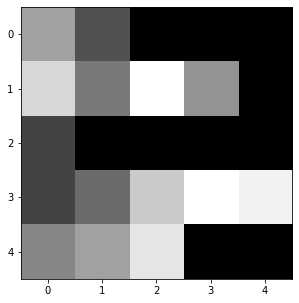

In [30]:
import matplotlib.pyplot as plt
from PIL import Image as im 

%matplotlib inline
fig=plt.figure(figsize=(5, 5))
plt.imshow(arr,cmap='gray')
plt.show()

### <a name="ambient"></a>Ambiente de CPMP (containeryard.py)
ContainerYard se utilizará para que la red pueda tomar la observación y realizar acciones en el estado. Más información sobre gym puede ser leída en su página web: https://gym.openai.com/

Los métodos que utilizaremos para explicar serán:
`reset()`: Reiniciará el problema actual, cargando otro (En el caso de este ejemplo, siempre cargará uno, pero en la realidad cargará el siguiente!!)

`step(action)`: Realizará una acción utilizando _take_action(action), después, calculará la recompensa del estado y entregará la **observación**, **recompensa**, un **boolean** definiendo si el estado es terminal y, opcionalmente, **información de debug**. 

`_take_action(action)`: Este método realizará la acción en el estado. Primero calculará lo que se demora el greedy en realizar la acción, y lo guardará para calcular la recompensa. Después, utilizará el método de `Yard`, `moveStack` para realizar la acción en el estado.

`_next_observation()`: Entregará la observación para la red, descrita anteriormente en el inicio de este archivo

`render()`: Este método imprimirá en pantalla el estado actual, de modo que una persona pueda leer en lo que va el estado actualmente. En una versión futura se podrá habilitar para que esta visualización sea gráfica en vez de basada en texto en la terminal.


In [31]:
# From containeryard.py
class ContainerYard(gym.Env):
    metadata = {'render.modes':['human']}

    #state : Yard
    #showDebug : bool
    #max_step : int
    #training : bool
    #fileStack : list
    #current_step : int
    #last_reward : int
    #x: int
    #y: int

    episodes=0
    
    def __init__(self, showDebug = False, x=5, y=5, max_containers=10):
        super(ContainerYard, self).__init__()

        self.x = x
        self.y = y
        self.max_containers = max_containers

        ### START OF CONFIG ###
        self.showDebug = showDebug
        self.max_step = 10

        #---> Creting the stack for files to use..
        self.fileStack = []
        
        ############################
        self.current_step = 0
        self.last_reward = 0

        # Start The Episode
        self.reset()

        """ Action Space: Valores del tamano
                vertical del patio.

        """

        self.action_space = spaces.Discrete(self.state.x)

        self.observation_space = spaces.Box(low=-1, high=255, shape=(self.state.x*self.state.y + self.state.x ,), dtype=np.float_)


    def _loadStack(self, path):
        for subdir, _, files in os.walk(FILE_PATH + path):
            for file in files:
                if "optimo" not in file:
                    full = subdir + os.sep + file
                    if os.path.isfile(full):
                        self.fileStack.append(full)

    def _next_observation(self):
        
        #Normalization and Generating the Yard Observation
        obs = self.state.getAsObservation()
                
        #Misc Observation
        for i in range(self.state.x):
            obs = np.insert(obs, obs.size, 1 if self.state.isSorted(i) is True else 0)
        
        #self.state.render()
        return obs
    
    def _take_action(self, action):

        layoutState = self.state.asLayout()
        dest = select_destination_stack(
            Layout(layoutState, self.state.y), 
            action
        )
        if dest==None: return None
        return self.state.moveStack(action, dest)



    def step(self, action):
        #Taking Action!
        ret = self._take_action(action)

        #New Greedy Value.
        self.greedy_steps = greedy_solve(
            Layout(self.state.asLayout(), self.state.y)
        )

        self.current_step += 1

        formula_reward = np.power(0.95, self.current_step + self.greedy_steps)
        reward = 100*(formula_reward - self.last_reward)
        self.last_reward = formula_reward
        
        
        #if self.state.isDone(): reward=1

        done = (self.state.isDone() or self.current_step >= self.max_step)

        if ret == None:
            #Could not make action, so we punish it.
            reward = -10
            done = True
    

        ##################
        ##  DEBUG INFO  ##  
        ##################
        if self.showDebug is True:
            info ={
                "current_step" : self.current_step,
                "greedy_steps" : self.greedy_steps,
                "max_step" : self.max_step,
                "reward" : reward,
                "current_action" : action,
                "action_status" : str(ret),
                "stackSize" : len(self.fileStack),
                "sorted" : str(self.state.isDone()),
            }
        else:
            info = None

        obs = self._next_observation()

        return obs, reward, done, info
            

    def reset(self):
        #Resetting
        ContainerYard.episodes += 1
        self.current_step = 0
        self.greedy_steps  = 0
        while self.greedy_steps  == 0  :
            self.state, self.layout, self.max_step = \
                random_generator(x=self.x, y=self.y, n_containers=self.max_containers)
            self.greedy_steps  = greedy_solve( Layout(self.state.asLayout(), self.state.y) )
        
        self.last_reward = np.power(0.95, self.greedy_steps)
        return self._next_observation()

    def render(self, mode=None, test=False):
        self.state.render()


### <a name="test"></a>Pruebas
Aquí realizaremos pruebas para que se comprenda el funcionamiento.

Iniciaremos el estado y probaremos sus funcionamientos básicos.

`gym_representation` será nuestro ambiente de gym, primero mostraremos con `.state.render()` cómo es que verá la persona el ambiente y con `._next_observation()` lo que ve la red.

PARA HUMANOS
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [20  0  8  0  0]
 [ 9  8 14  0  0]
 [20  1 17 10 10]]
Estado transformado: (Como arreglo)
[1.         0.28571429 0.28571429 0.57142857 0.57142857 0.42857143
 0.14285714 0.71428571 1.         1.         1.         1.
 0.85714286 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


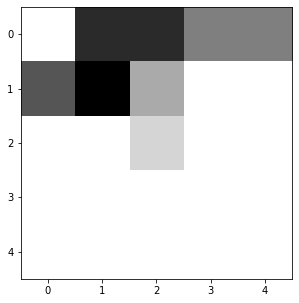


Observacion (anterior + 0/1 si stack esta ordenado o no)
[1.         0.28571429 0.28571429 0.57142857 0.57142857 0.42857143
 0.14285714 0.71428571 1.         1.         1.         1.
 0.85714286 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.         0.         1.         1.         1.        ]


In [32]:
import matplotlib.pyplot as plt
from PIL import Image as im 

gym_representation = ContainerYard()

print('PARA HUMANOS')
gym_representation.state.render()

print('Estado transformado: (Como arreglo)')
print(gym_representation.state.getAsObservation())

%matplotlib inline
fig=plt.figure(figsize=(5, 5))

arr=gym_representation.state.getAsObservation()
arr.shape=(5,5)

plt.imshow(arr,cmap='gray')
plt.show()

print('\nObservacion (anterior + 0/1 si stack esta ordenado o no)')
print(gym_representation._next_observation())

Ahora, probaremos un par de funciones.
Comenzaremos probando realizar un movimiento sobre la columna numero 3 (Si contamos desde 0, sería la número 2.)

El método retornara cuatro valores:
La nueva observación, la recompensa, si el estado es terminal y, por último, información adicional opcional.

In [33]:
print("Información de Retorno: (Observacion, recompensa, es estado terminal?, información debug [OPCIONAL])")
print(gym_representation.step(1))

print("\nRender:")
gym_representation.state.render()

Información de Retorno: (Observacion, recompensa, es estado terminal?, información debug [OPCIONAL])
(array([1.        , 0.14285714, 0.28571429, 0.57142857, 0.57142857,
       0.42857143, 1.        , 0.28571429, 1.        , 1.        ,
       1.        , 1.        , 0.71428571, 1.        , 1.        ,
       1.        , 1.        , 0.85714286, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ]), 0.0, False, None)

Render:
[[ 0  0  0  0  0]
 [ 0  0  8  0  0]
 [20  0  8  0  0]
 [ 9  0 14  0  0]
 [20  1 17 10 10]]


A continuación utilizaremos los métodos que se utilizan dentro de todas las funciones:

In [34]:
print("Stacks Ordenados: ")
print(gym_representation.state.getAllSorts())


print("\nEs Estado Terminal: ")
print(gym_representation.state.isDone())

print("\nValor Greedy Estado Actual - Pasos Tomados: ")
print(greedy_solve(Layout(gym_representation.state.asLayout(), gym_representation.state.y)), gym_representation.current_step)

print('\nEstado Actual:')
gym_representation.state.render()

Stacks Ordenados: 
[False  True  True  True  True]

Es Estado Terminal: 
False

Valor Greedy Estado Actual - Pasos Tomados: 
2 1

Estado Actual:
[[ 0  0  0  0  0]
 [ 0  0  8  0  0]
 [20  0  8  0  0]
 [ 9  0 14  0  0]
 [20  1 17 10 10]]


## <a name="execute"></a>Ejecutar el Ambiente
Un ejemplo de la ejecucion del ambiente puede ser vista en el archivo [DQN_Optimizer.py](https://github.com/Nyuku/CPMP-AI/tree/master/DQN_Optimizer.py). En esta demonstracion se utilizara la libreria `stable_baselines`, de modo que solo nos fijemos en el ambiente y su utilizacion.

### Configuracion
Primero, tenemos los `timesteps`. Esta variable definirá la cantidad de pasos que realizará la red para aprender, mientras más mejor, claro.
Segundo, tenemos la configuración del ambiente. El Objeto de ambiente se instanciará con los siguientes aributos:

- `showDebug` : Entregará información adicional de Debug, como la recompensa en el estado actual, la cantidad de pasos que ha tomado y los máximos, etc.
- `x` : Ancho del problema
- `y` : Alto del Problema

Un ejemplo de instanciación del problema sería: `ContainerYard(showDebug = True)`, en este ejemplo, se mostrará la información de debug y se utilizarán las dimensiones por defecto del problema: 20x5.


### Utilizar el Ambiente
Para utilizar el ambiente se tendra que tener en cuenta las funciones importantes del ambiente. En estas tenemos:

`reset`: este metodo reinicia el problema actual para dar paso al siguiente, retorna una observacion en formato red para alimentar a esta.

`step`: este metodo recibe una accion en formato entero, de 1 a x, donde x sera el ancho del problema. Step deolvera, al igual que reset, una observacion del ambiente. Ademas, devolvera la recompensa de la accion, un boolean que dictamina si es un paso final o no y, opcionalmente, una informacion de debug.

`render`: este metodo mostrara por pantalla el estado actual en la terminal

In [37]:
import gym


#   Se cargan las librerias que se utilizaran para probar el ambiente.  
#   Se utilizara DQN para probar.
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN

#   Cargamos el Script que contiene el ambiente
#import containeryard.containeryard
#from containeryard.containeryard import ContainerYard
#import importlib
#importlib.reload(containeryard.containeryard)


#Para evitar que sea mucho tiempo, ejecutaremos 1000 veces, solo para que se vea como funciona.
timesteps = 40000

# Se crea el ambiente:
# showDebug -> Permite ver la informacion de debug que se guardara en la variable info abajo.
# training -> Los generadores crean conjuntos d prueba y entrenamiento, para evitar que este utilice los mismos
#             ejemplos en cada momento. Aqui define que utilizara solo el conjunto de entrenamiento
env = DummyVecEnv([lambda: ContainerYard(showDebug = True, x=5, y=5, max_containers=10)])

#Se crea el modelo, utilizando stable_baselines.
model = DQN(MlpPolicy, env, verbose=0)

#Aqui se entrena!
model.learn(total_timesteps=timesteps)


for i_episode in range(10): # Se probaran 5 problemas diferentes.
    cur_step = 0

    #Comenzamos con un reset, para tomar el siguiente problema.
    print("========= Reset =========")
    print("Problema Numero ",str(i_episode+1))
    print("=========================")

    obs = env.reset()

    env.render()
    print("=====COMENZANDO A RESOLVER=====")

    while True:
        # El modelo usara la funcion para predecir cual es la mejor
        # accion para la observacion "obs"
        act, _states = model.predict(obs)

        #Se utilizara la accion "act" que entrego la red para ser utilizada en la
        #funcion "step". Esta devolvera una observacion, una recompensa, un boolean que dira
        #si finalizo el episodio y, finalmente informacion de debug en "info".
        obs, reward, done, info = env.step(act)

        #mostrara en la terminal el estado actual.
        env.render()
        cur_step += 1
        print("PASO NUMERO {0}".format(cur_step))
        print("SE ELIGIO EL STACK {0}\n".format(act))
        print("LA RECOMPENSA ES DE {0}\n".format(reward))
        print("STEPS {0}\n".format(info))
        

        if done:
            # Si es terminal, entonces se termina y se comienza con el siguiente problema.
            break

print("Se completaron los problemas!")
env.close()